In [1]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet 
import statsmodels.tsa.stattools as ts
 
from helper import clean_data
from helper import vix_prime_combine
from helper import dftest
from helper import split_data

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
weekly_pct, vix_close = clean_data()

## Checks from class notebooks (timeseries_autocorrelation)

In [7]:
weekly_vix = vix_close.resample('W').mean()
monthly_vix = vix_close.resample('M').mean()

In [8]:
len(weekly_vix.index.unique())

1516

In [9]:
weekly_vix.index.max() - weekly_vix.index.min()

Timedelta('10605 days 00:00:00')

In [10]:
res = []
for i in range(1,100):
    res.append(weekly_vix.vix_close.autocorr(lag=i))

In [11]:
for i in range(360,370):
    print(i, weekly_vix.vix_close.autocorr(lag=i))

360 -0.10631333975074628
361 -0.10537657192508124
362 -0.1047285227203106
363 -0.10234715218964859
364 -0.09882673404518973
365 -0.09666553367753829
366 -0.09422826533172199
367 -0.08915533741426662
368 -0.08173508141821138
369 -0.07603158397100884


In [12]:
np_res = np.array(res)

In [13]:
np_res.argmin()

98

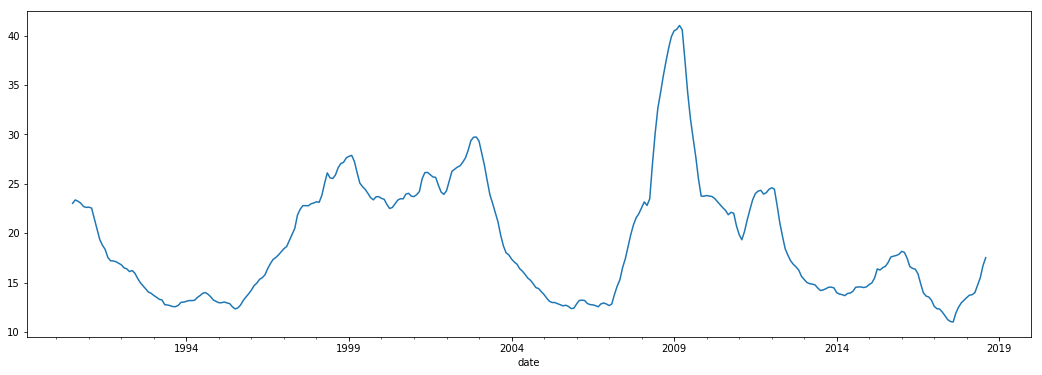

In [14]:
monthly_vix.vix_close.rolling(window=12,center=True).mean().plot(figsize=(18,6))

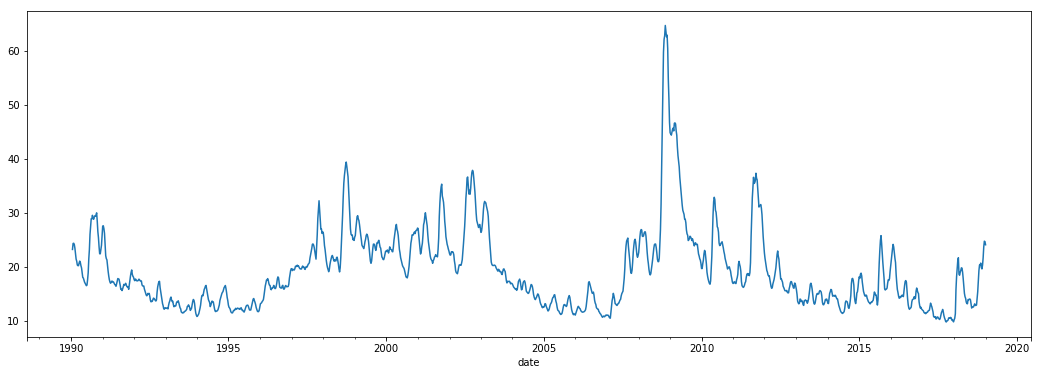

In [15]:
weekly_vix.vix_close.rolling(window=5, center=True).mean().plot(figsize=(18,6));

In [16]:
pct_series = weekly_vix.vix_close.diff()/weekly_vix.vix_close

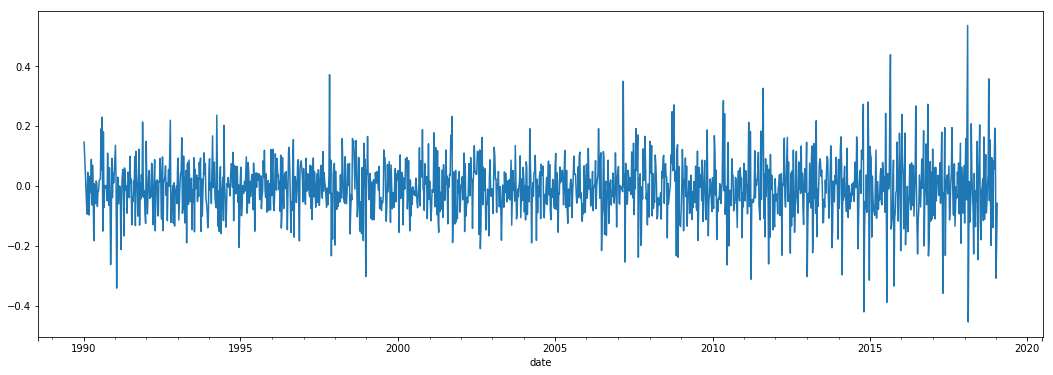

In [17]:
pct_series.plot(figsize=(18,6))

In [18]:
weekly_vix.vix_close.autocorr(lag=52*12)

0.1962742188417796

In [19]:
print(weekly_vix.vix_close.std())
print(weekly_vix.vix_close.diff().std()) ## this may be best.
print(weekly_vix.vix_close.diff().diff().std())

7.694458772199208
2.2072060984407402
3.162295968102394


## Data Distribution

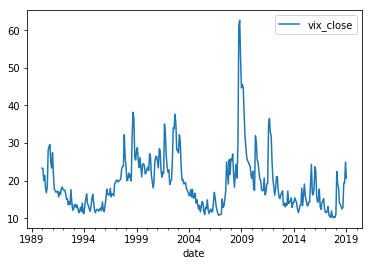

In [20]:
monthly_vix.plot() ## do I need to worry about the financial meltdown? Probably.

In [21]:
monthly_vix.columns

Index(['vix_close'], dtype='object')

In [22]:
annual_vix = vix_close.resample('A').mean()

In [23]:
%config InlineBackend.figure_format = 'svg'

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


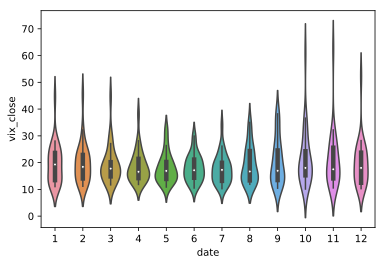

In [24]:
a = sns.violinplot(x=monthly_vix.index.month,y=monthly_vix.vix_close)
figure = a.get_figure()
figure.savefig('monthly_vix_violin.svg',  bbox_inches='tight')

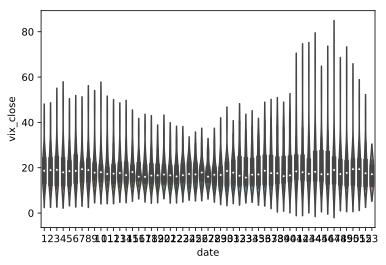

In [25]:
sns.violinplot(x=weekly_vix.index.week,y=weekly_vix.vix_close) ## volitility spikes in fall and winter

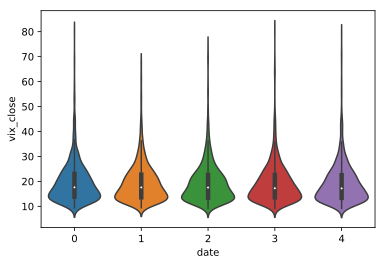

In [26]:
sns.violinplot(x=vix_close.index.dayofweek,y=vix_close.vix_close) #Monday - Friday doesn't matter.

In [27]:
smt.graphics.plot_pacf(pct_df.resample('W').mean(), lags=24)

NameError: name 'smt' is not defined

## tests from class

In [ ]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


In [ ]:
plots(pct_df.resample('W').mean(), lags=24);


In [ ]:
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_vix.vix_close, order=(1,1,0), seasonal_order=(1,0,0,12), trend='c').fit()
sar.summary()

In [ ]:
plots(sar.resid, lags=40);

In [ ]:
sar.plot_diagnostics(figsize=(10, 8));